In [216]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from math import cos, log2

In [2]:
def easy_smooth_wave(x, period): 
    #granularity is a power of 2, how fine or coarse we wanna make the wave
    p = x%period #get relative position in cycle (can take care of this when you increment x)

    """
    # 19 operations
    q = (period >> 2)
    p0 = p - q #subtract the first quarter period
    p1 = p0 - q #subtract the second quarter period
    p2 = p1 - q #subtract the third quarter period
    # check which range:
    int0 = ((p0) >> 15) & 1
    int1 = ~((p0) >> 15) & ((p1) >> 15) & 1 
    int2 = ~((p1) >> 15) & ((p2) >> 15) & 1  
    int3 = ~((p2) >> 15) & 1
    """
    
    # 18 operations
    q4 = (period >> 2)
    q2 = (period >> 1)
    p0 = (p - q4) >> 15
    p1 = (p - q2) >> 15 
    p2 = (p - q2 - q4) >> 15
    # check which range:
    t0 = p0 & 1
    t1 = ~p0 & p1 & 1 
    t2 = ~p1 & p2 & 1  
    t3 = ~p2 & 1
    
    #1<<15
    
    """
    1 - (p/period)**2          #int0
    (1-(p/period))**2 - 1      #int1
    (p/period)**2 - 1          #int2
    1 - (1 - (p/period))**2    #int3
    """
    
    """
    let P = (p/period)
    
    0:  1-P^2
    1:  (1-P)^2 - 1 = 1 - 2P + P^2 - 1 = P^2 - 2P
    2:  P^2 - 1
    3:  1 - (1-P)^2 = 1 - (1 - 2P + P^2) = 2P - P^2
    
    aP^2 + bP + C
        a  b  c
    0: -1  0  1
    1:  1 -2  0
    2:  1  0 -1
    3: -1  2  0
    
    a = (-1 * (t0 | t3)) + (t1 | t2)
    b = (-2 * t1) + (2 * t3)
    c = (t0) - (t1 | t2)
    """
    
#   P = (p - ((t1 + t2*2 + t3*3) * (period >> 2))) / (period>>2)
    # (p - xT)
    sub = (t1 + (t2<<1) + t3 + (t3<<1))
    ran = 1 << 7 #range
#     P = (p)/(period>>2) - sub
    
    a = (t1 | t2) - (t0 | t3)
    b = (t3 - t1)<<1
    c = (t0 - t2)
    
    P = (p % (period >> 2))/(period >> 2)
    
    print(np.round(P, 5), "\t", t0, t1, t2, t3)
    
    return (a*P*P + b*P + c)

0.0 	 1 0 0 0
0.0625 	 1 0 0 0
0.125 	 1 0 0 0
0.1875 	 1 0 0 0
0.25 	 1 0 0 0
0.3125 	 1 0 0 0
0.375 	 1 0 0 0
0.4375 	 1 0 0 0
0.5 	 1 0 0 0
0.5625 	 1 0 0 0
0.625 	 1 0 0 0
0.6875 	 1 0 0 0
0.75 	 1 0 0 0
0.8125 	 1 0 0 0
0.875 	 1 0 0 0
0.9375 	 1 0 0 0
0.0 	 0 1 0 0
0.0625 	 0 1 0 0
0.125 	 0 1 0 0
0.1875 	 0 1 0 0
0.25 	 0 1 0 0
0.3125 	 0 1 0 0
0.375 	 0 1 0 0
0.4375 	 0 1 0 0
0.5 	 0 1 0 0
0.5625 	 0 1 0 0
0.625 	 0 1 0 0
0.6875 	 0 1 0 0
0.75 	 0 1 0 0
0.8125 	 0 1 0 0
0.875 	 0 1 0 0
0.9375 	 0 1 0 0
0.0 	 0 0 1 0
0.0625 	 0 0 1 0
0.125 	 0 0 1 0
0.1875 	 0 0 1 0
0.25 	 0 0 1 0
0.3125 	 0 0 1 0
0.375 	 0 0 1 0
0.4375 	 0 0 1 0
0.5 	 0 0 1 0
0.5625 	 0 0 1 0
0.625 	 0 0 1 0
0.6875 	 0 0 1 0
0.75 	 0 0 1 0
0.8125 	 0 0 1 0
0.875 	 0 0 1 0
0.9375 	 0 0 1 0
0.0 	 0 0 0 1
0.0625 	 0 0 0 1
0.125 	 0 0 0 1
0.1875 	 0 0 0 1
0.25 	 0 0 0 1
0.3125 	 0 0 0 1
0.375 	 0 0 0 1
0.4375 	 0 0 0 1
0.5 	 0 0 0 1
0.5625 	 0 0 0 1
0.625 	 0 0 0 1
0.6875 	 0 0 0 1
0.75 	 0 0 0 1
0.8125 	 0 0 0 1
0

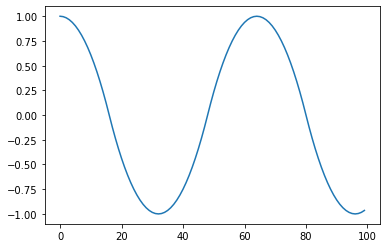

In [3]:
n = np.asarray([easy_smooth_wave(x, 64) for x in range(100)])
plt.plot(n)
plt.show()

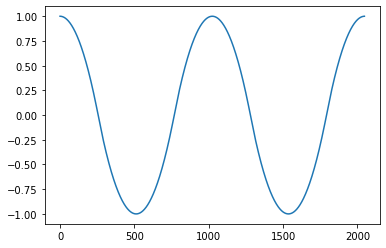

In [6]:
def wav2(x, M): #M is the granularity (i.e. 1 cycle every 1024 samples means M = 10)
    
    p = x & ((1<<M) - 1)
    
    q4 = (1 << (M-2))
    q2 = (1 << (M-1))
    p0 = (p - q4) >> 15
    p1 = (p - q2) >> 15 
    p2 = (p - q2 - q4) >> 15
    # check which range:
    t0 = p0 & 1
    t1 = ~p0 & p1 & 1 
    t2 = ~p1 & p2 & 1  
    t3 = ~p2 & 1
    
    a = (t1 | t2) - (t0 | t3)
    b = (t3 - t1)<<1
    c = (t0 - t2)
    
    t = (t1 + (t2<<1) + t3 + (t3<<1)) >> (M - 2)
    
    s1 = (p - t)
    
    P = (p % q4)/(q4)
    
#     print(np.round(P, 5), "\t", t0, t1, t2, t3)
    
    return (a*P*P + b*P + c)
    
    
    

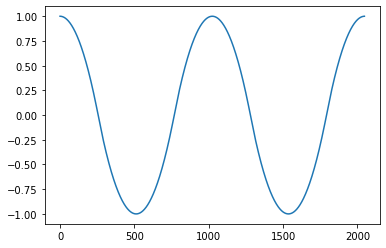

In [7]:
n = np.asarray([wav2(x, 10) for x in range(2048)])
plt.plot(n)

# n2 = np.asarray([wav2(x, 9) for x in range(2048)])
# plt.plot(n2)

plt.show()

In [19]:
def wav_1024(x): #we have one cycle every 1024 samples, the output is in the range [-(2^15), 2^15]
    
    p = x & 1023
    
    p0 = (p - 256) >> 15
    p1 = (p - 512) >> 15 
    p2 = (p - 768) >> 15
    # check which range:
    t0 = p0 & 1
    t1 = ~p0 & p1 & 1 
    t2 = ~p1 & p2 & 1  
    t3 = ~p2 & 1
    
    a = (t1 | t2) - (t0 | t3)
    b = (t3 - t1) << 8
    c = (t0 - t2) << 15
    
    t = (t1 + (t2<<1) + t3 + (t3<<1)) << 8
    s1 = (p - t)
    assert s1 >= 0
    return ((((a * s1)>>1) + b) * s1  + c) #256 * b because we don't multiply b by 2 above

    #35 instructions


In [260]:
def gen_gran_code(exp):
    val = 1<<exp
    s = """
    p = x & {}
    
    p0 = (p - {}) >> {} 
    p1 = (p - {}) >> {} 
    p2 = (p - {}) >> {}
    
    t0 = p0 & 1
    t1 = ~p0 & p1 & 1 
    t2 = ~p1 & p2 & 1  
    t3 = ~p2 & 1
    a = (t1 | t2) - (t0 | t3)
    b = (t3 - t1) << {}
    c = (t0 - t2) << {}
    
    p = p & {}
    
    return ((a * p + b) * p + c)
    """.format(val-1, int(val * 0.25), exp, int(val * 0.50), exp, int(val * 0.75), exp, exp-1, 2*(exp - 2), ((1<<(exp-2)) - 1))
    
    print(s)

In [261]:
gen_gran_code(15)


    p = x & 32767
    
    p0 = (p - 8192) >> 15 
    p1 = (p - 16384) >> 15 
    p2 = (p - 24576) >> 15
    
    t0 = p0 & 1
    t1 = ~p0 & p1 & 1 
    t2 = ~p1 & p2 & 1  
    t3 = ~p2 & 1
    a = (t1 | t2) - (t0 | t3)
    b = (t3 - t1) << 14
    c = (t0 - t2) << 26
    
    p = p & 8191
    
    return ((a * p + b) * p + c)
    


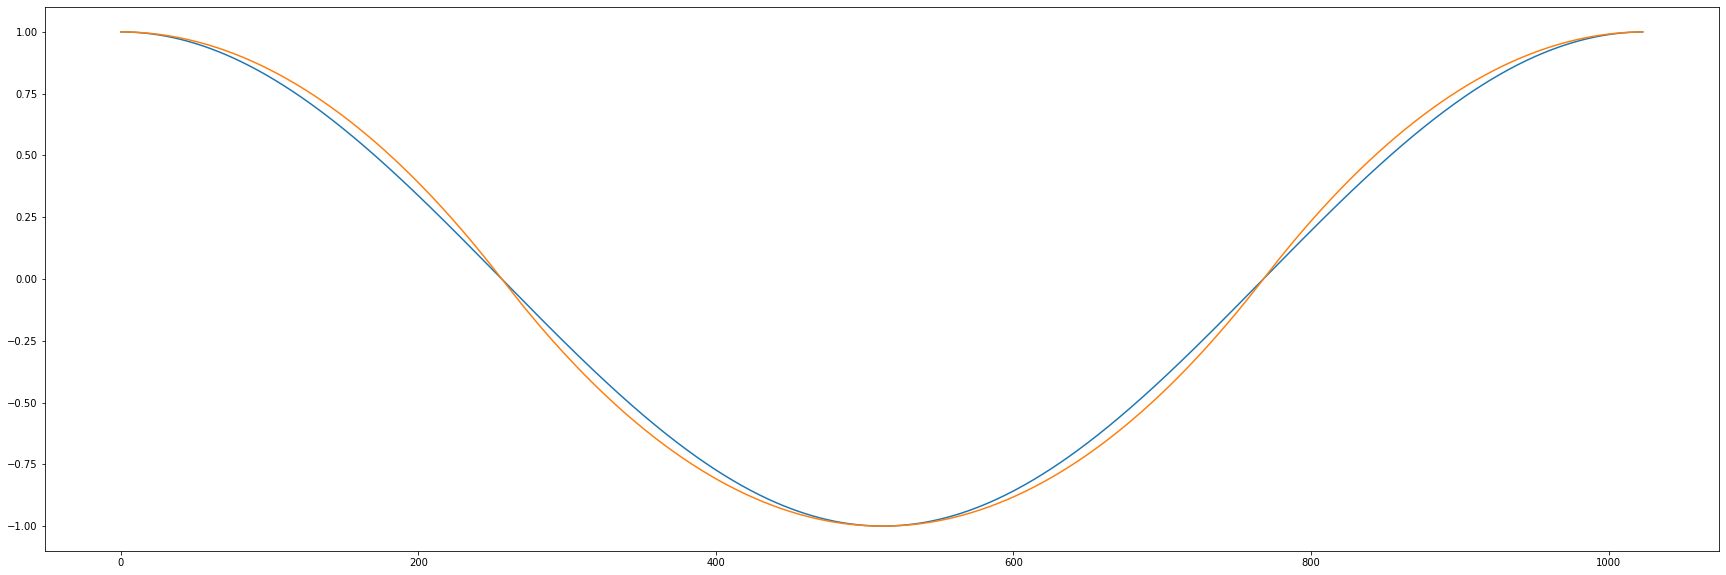

In [307]:
"""
Problem: approximate a sinusoidal function under the following constraints:

Instructons we are allowed to use:

shifting, addition, negation, logical and, logical or, multiplication

N a division instructionOTE: the distinct lack of


furthermore, there is also no support for floating point numbers:

"""
plt.figure(figsize=(30,10))
plt.plot([cos((i * np.pi * 2)/1024.0) for i in range(1024)])

# first order taylor series approximation over four periods
q1 = np.asarray([1 - (i/256.0)**2 for i in range(256)])
q2 = np.asarray([(1 - (i/256.0))**2 - 1 for i in range(256)])
q3 = np.asarray([((i/256.0))**2 - 1 for i in range(256)])
q4 = np.asarray([ 1 - (1 - (i/256.0))**2 for i in range(256)])


approx = np.concatenate((q1, q2, q3, q4))
plt.plot(approx)

plt.show()



In [318]:
1<<13

8192

In [324]:
def wav_32768(x):
    p = x & 32767
    
    p0 = (p - 8192) >> 15 
    p1 = (p - 16384) >> 15 
    p2 = (p - 24576) >> 15
    
    t0 =  p0 & 1
    t1 = ~p0 & p1 & 1 
    t2 = ~p1 & p2 & 1  
    t3 = ~p2 & 1
    
    a = (t1 | t2) - (t0 | t3)
    b = (t3 - t1) << 14
    c = (t0 - t2) << 26
    
    p = p & 8191
    
    return ((a * p + b) * p + c) 

#35 -> 34 -> 29 -> 28 total instructions

In [540]:
def gen_code(r):
    print( 
    """
    a = x >> {}
    b = (a & 2) - 1    
    c = (a & 1) << {} 
    d = x & {}
    return b * (((d + c - {})*d) - (c << {}))
    """.format(r, r+1, (1<<r)-1, 1<<(r+1), r-1)
    )

def n2_wav(x):
    a = x >> 13
    b = (a & 2) - 1    
    c = (a & 1) << 14 
    d = x & 8191
    return b * (((d + c - 16384)*d)- (c << 12))
    # 12 instructions

In [541]:
gen_code(13)


    a = x >> 13
    b = (a & 2) - 1    
    c = (a & 1) << 14 
    d = x & 8191
    return b * (((d + c - 16384)*d) - (c << 12))
    


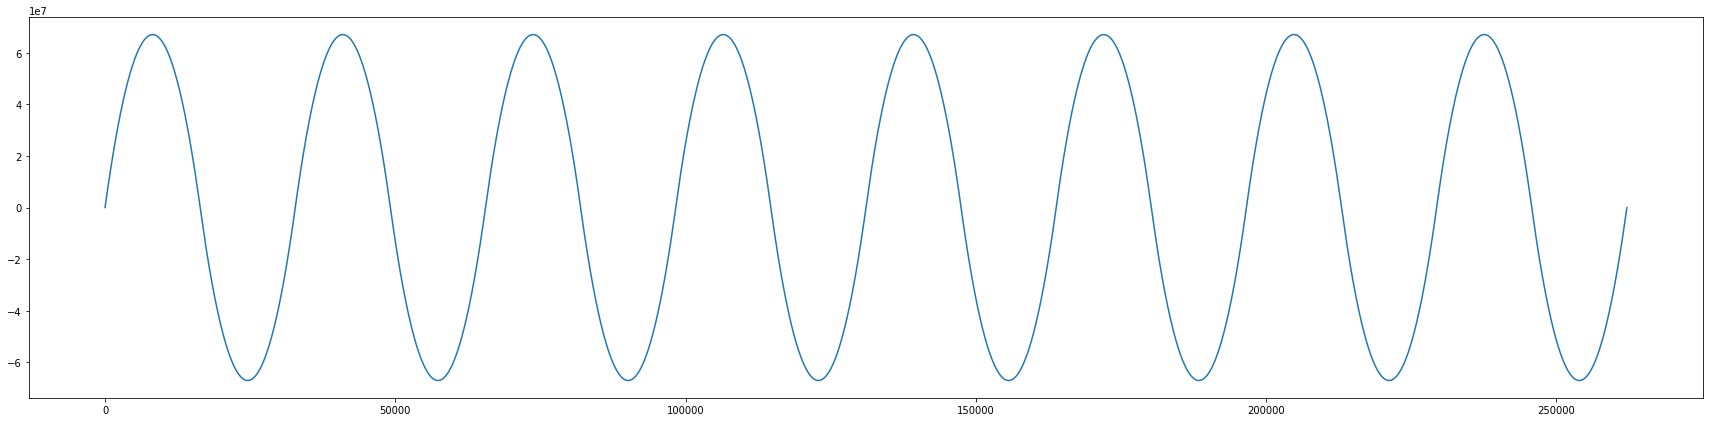

67108864


In [542]:
n = np.asarray([n2_wav(x) for x in range(1<<18)])
plt.figure(figsize=(30,7))
# plt.scatter(np.arange(1<<10), n)
plt.plot(n)
plt.show()
print(max(n))

In [434]:
def asm_32768_2(r0): # 13 instructions, 5 registers
    """
    a = x >> 13
    b = (a & 2) - 1    
    c = (a & 1) << 14 
    d = x & 8191
    return b * (((d + c - 16384)*d) - (c << 12))
    """
    r1 = r0 >> 13
    r2 = r1 & 2
    r2 = r2 - 1
    r3 = r1 & 1
    r3 = r3 * r2
    r1 = r2 - r3
    r1 = r1 << 14
    r3 = r3 << 26
    r4 = r0 & 8191
    r2 = r2 * r4
    r2 = r2 - r1
    r2 = r2 * r4
    r2 = r2 - r3
    return r2

In [510]:
def n_wav_32768(x):
    b = x >> 13
    lb = (b & 2) - 1    #[-1, 1]
#     lbrb = lb * (b & 1) #[-1, 0, 1]
    rb = (b & 1)
#     b = (lb - lbrb) << 14
#     c = lbrb << 26
    p = x & 8191
#     return ((lb * p - b) * p - c) 
#     return (lb * (p + ((rb - 1)<<14)))*p - c
    return lb * (((p + ((rb-1)<<14))*p) - ((rb) << 26))
    #35 -> 34 -> 29 -> 28 -> 25 -> 24 -> 23 -> 21 -> 20 -> 16 -> 15 -> 13 total instructions

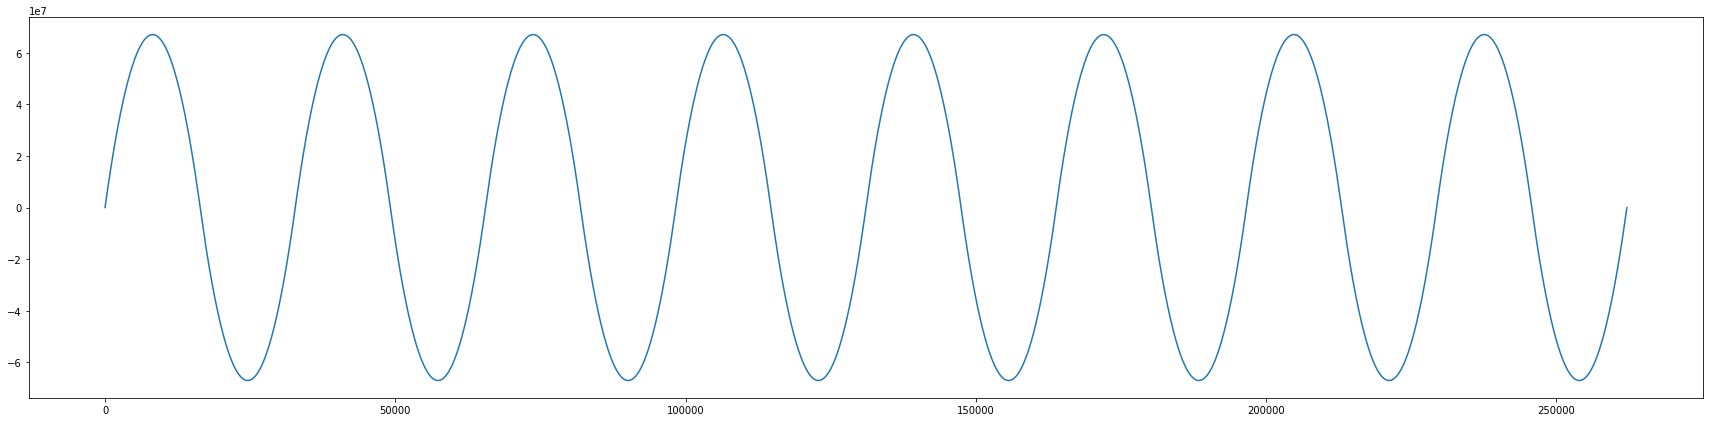

67108864


In [511]:
n = np.asarray([n_wav_32768(x) for x in range(1<<18)])
plt.figure(figsize=(30,7))
# plt.scatter(np.arange(1<<10), n)
plt.plot(n)
plt.show()
print(max(n))

In [435]:
def asm_32768(r7): #8 registers, 24 instructions
    r0 = r7 & 32767
    
    r1 = r0 >> 13
    r1 = r1 & 1
    
    r2 = r0 >> 14
    
    r3 = r1 | r2
    r3 = ~r3
    r3 = r3 & 1
    
    r4 = ~r2
    r4 = r4 & r1
    
    r5 = ~r1
    r5 = r5 & r2
    
    r6 = r1 & r2
    
    r2 = r4 | r5
    r1 = r3 | r6
    r0 = r2 - r1
    
    r1 = r6 - r4
    r1 = r1 << 14
    
    r2 = r3 - r5
    r2 = r2 << 26
    
    r3 = r7 & 8191
    
    r0 = r0 * r3
    r0 = r0 + r1
    r0 = r0 * r3
    r0 = r0 + r2
    return r0    

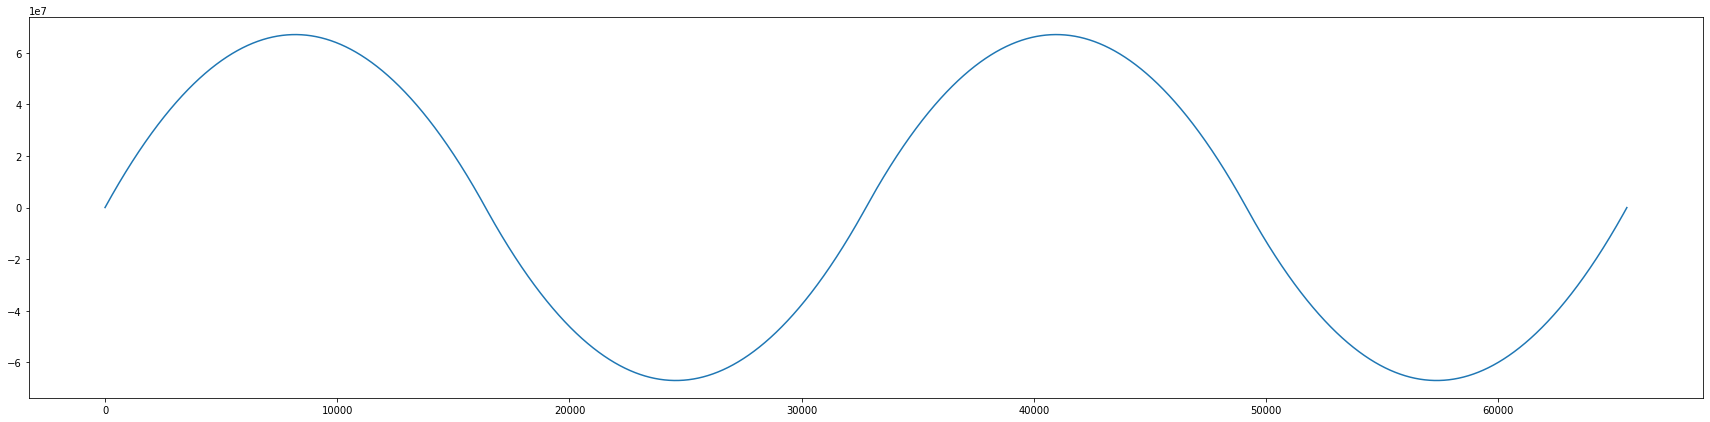

67108864


In [437]:
n = np.asarray([asm_32768_2(x) for x in range(1<<16)])
plt.figure(figsize=(30,7))
plt.plot(n)
plt.show()
print(max(n))

# def max_deviation(interval):
    ratios = [round((2**(i/12)) * interval) for i in range(12)]
    acc = [(2**(i/12)) * interval for i in range(12)]
    return max([abs(acc[i] - ratios[i])/acc[i] for i in range(12)])


In [197]:
max_deviation(116) # 116 has the smallest deviation up until at least 172


0.0015790227737577074

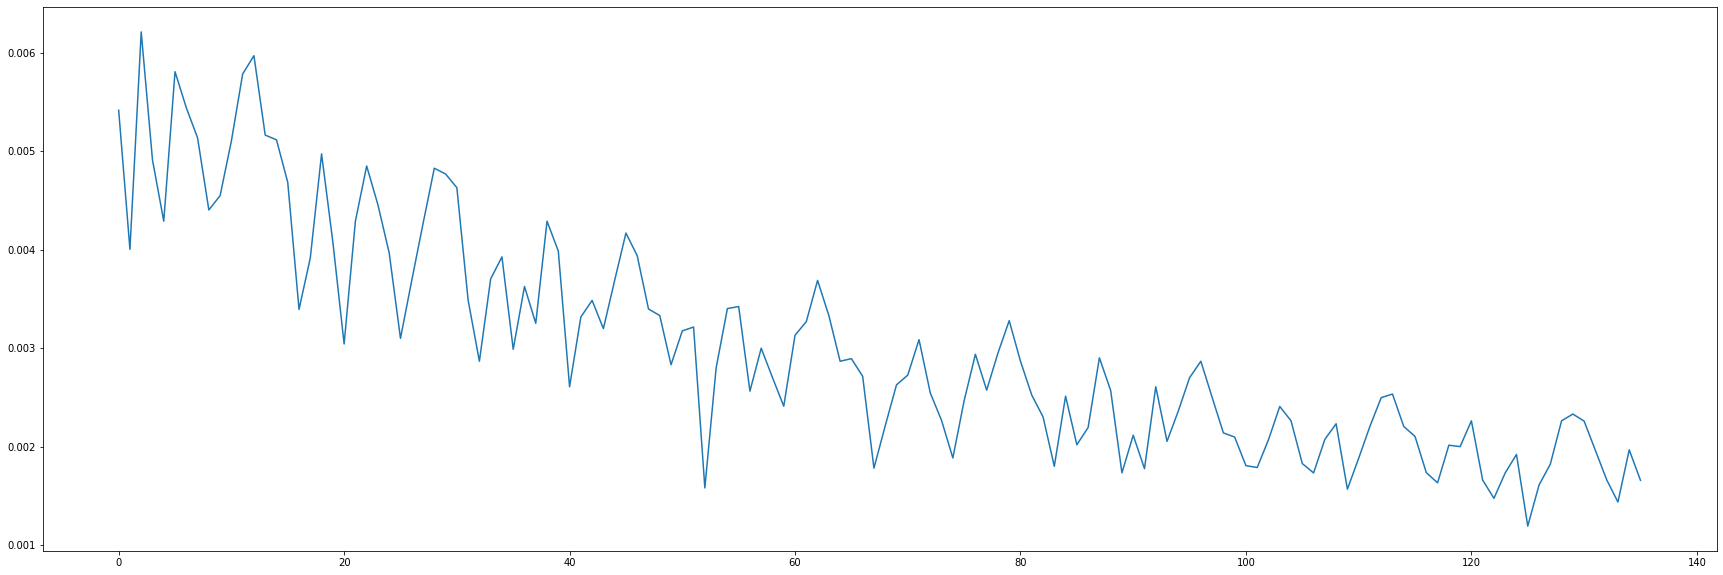

In [234]:
devs = [max_deviation(i) for i in range(64, 200)]
plt.figure(figsize=(30,10))
plt.plot(devs)
plt.show()

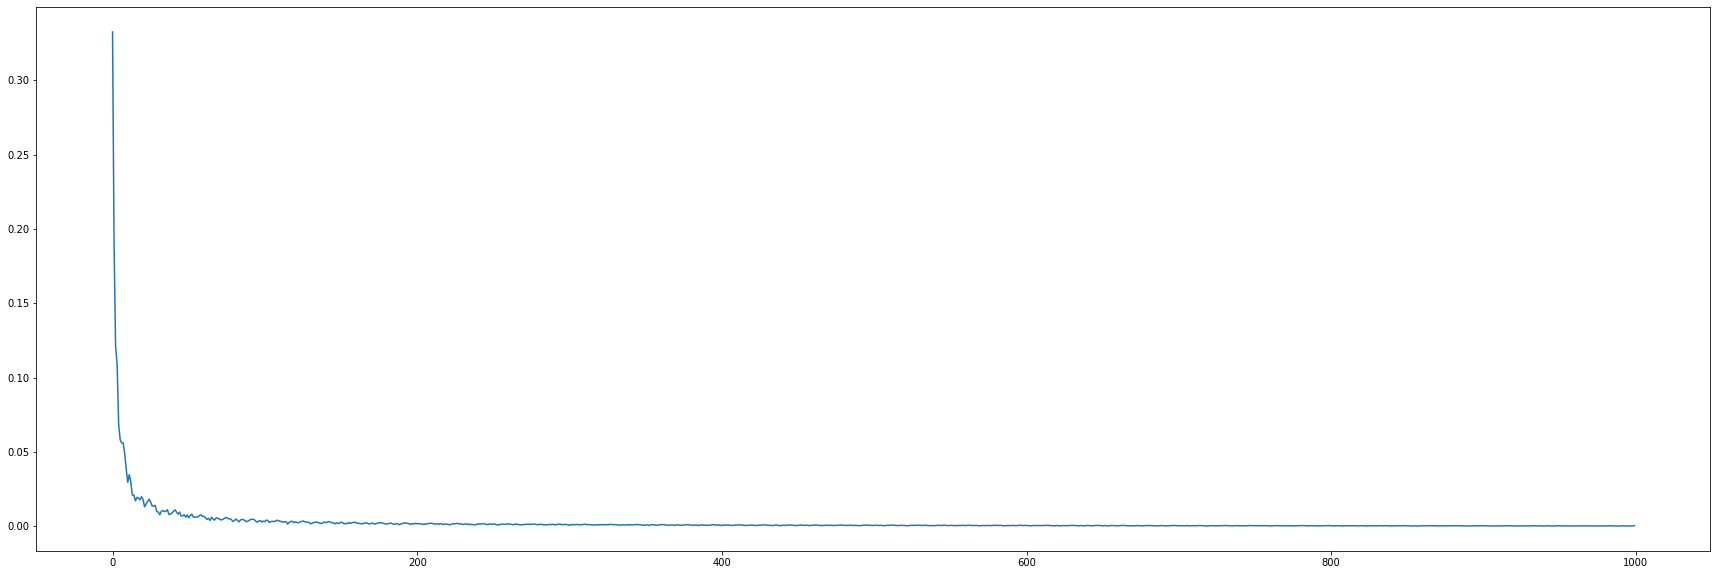

[(0, 1),
 (7, 0.056125687318306514, -1.6846381528425003),
 (11, 0.029681068380029246, -2.1677810649190055),
 (14, 0.02108850423665349, -2.514639052816466),
 (16, 0.0172312312803693, -2.7309204946541343),
 (22, 0.013222309469138641, -3.5251427584650945),
 (32, 0.007874342519875349, -4.578869354399749),
 (47, 0.0070415413125078955, -6.573524917164839),
 (49, 0.006224897989956158, -6.686923870676593),
 (51, 0.005778065303462581, -6.859266093611514),
 (63, 0.004724737258033714, -8.154759016853793),
 (65, 0.004004108811589794, -8.161417156674903),
 (80, 0.0033935032835459753, -9.752519010198172),
 (84, 0.0030419106524774767, -10.046877647398608),
 (96, 0.0028664572242993675, -11.365633509695398),
 (104, 0.0026072643409673878, -12.11662612676444),
 (116, 0.0015790227737577074, -12.4640686878596),
 (173, 0.0015664784927751604, -18.56569923758089),
 (186, 0.0014735318264551915, -19.773548089532223),
 (189, 0.0011912035114354704, -19.457727801139296),
 (222, 0.001143672155415793, -22.7177122737

In [233]:
devs = [max_deviation(i) for i in range(1, 1001)]
plt.figure(figsize=(30,10))
plt.plot(devs)
plt.show()


decr_local_minima = [(0, 1)]

for i in range(2, 1000):
    if devs[i-1] > devs[i] and devs[i+1] > devs[i]:
        if devs[i] <= decr_local_minima[-1][1]:
            decr_local_minima.append(
                (i + 1, devs[i], (i+1)/log2(devs[i]))
            ) 

decr_local_minima

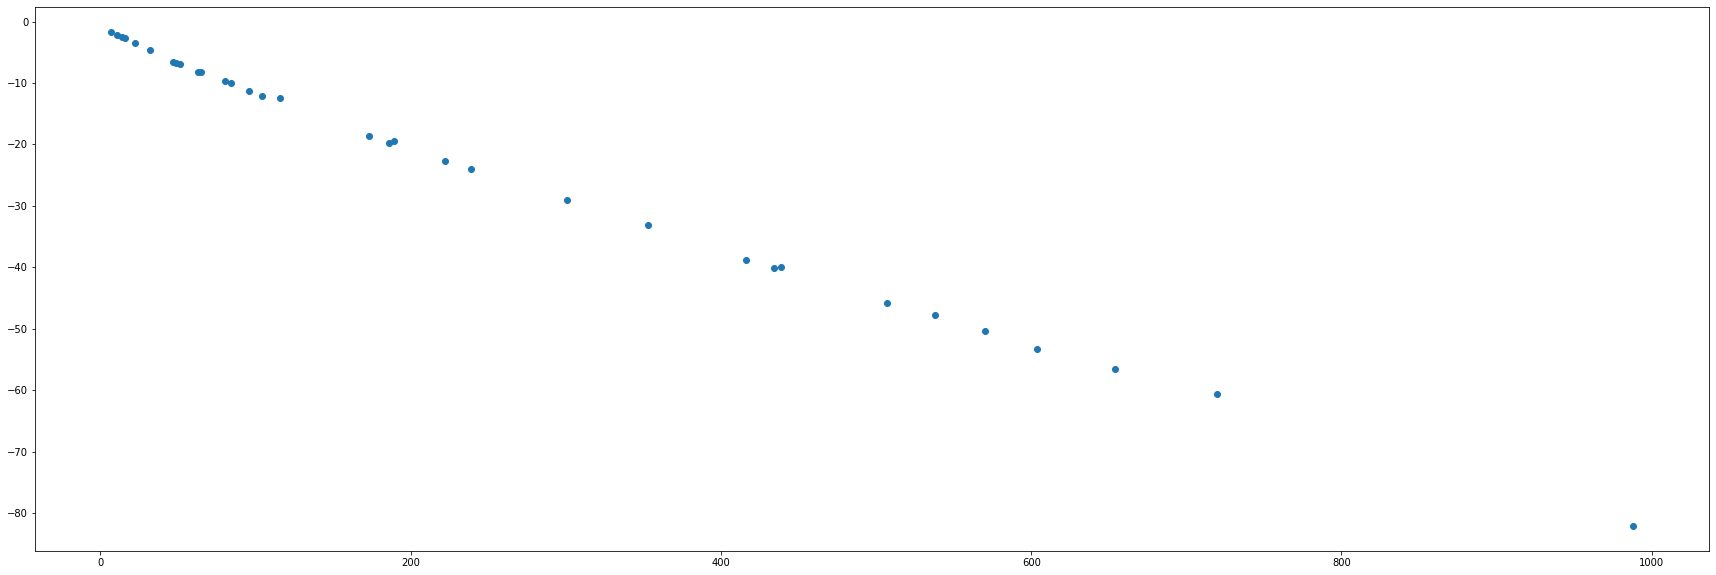

In [227]:
x_s = [d[0] for d in decr_local_minima[1:]]
y_s = [d[-1] for d in decr_local_minima[1:]]

plt.figure(figsize=(30,10))
plt.scatter(x_s, y_s)
plt.show()

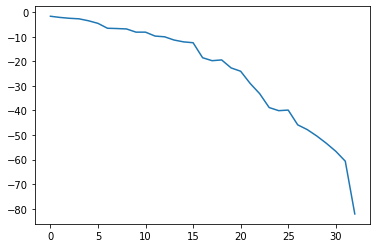

In [228]:
plt.plot(y_s)
plt.show()

In [203]:
interval = 116

ratios = [round((2**(i/12)) * interval) for i in range(12)]
print(ratios)
acc = [round((2**(i/12)) * interval, 4) for i in range(12)]
print(acc)

diffs = [round(abs(acc[i] - ratios[i])/acc[i], 5) for i in range(12)]
print(diffs)

print("Max Deviation with base note sample rate of {} is {}%".format(interval, (max(diffs)) * 100))
# at 240, the rounding error does not produce any issues

[116, 123, 130, 138, 146, 155, 164, 174, 184, 195, 207, 219]
[116.0, 122.8977, 130.2056, 137.948, 146.1508, 154.8414, 164.0488, 173.8036, 184.1385, 195.088, 206.6885, 218.9788]
[0.0, 0.00083, 0.00158, 0.00038, 0.00103, 0.00102, 0.0003, 0.00113, 0.00075, 0.00045, 0.00151, 0.0001]
Max Deviation with base note sample rate of 116 is 0.158%


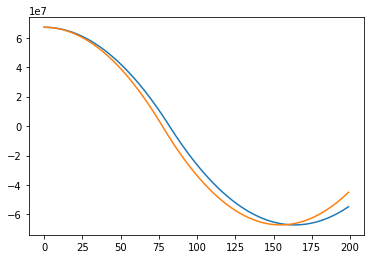

In [237]:
wav_240 = [wav_32768(i*100) for i in range(100000)]
wav_254 = [wav_32768(i*106) for i in range(100000)]
plt.plot(wav_240[:200])
plt.plot(wav_254[:200])

plt.show()

In [85]:
1<<26

67108864

In [67]:
def wav_4096(x): #we have one cycle every 1024 samples, the output is in the range [-(2^15), 2^15]
    p = x & 4095 #acts as modulus
    
    p0 = (p - 1024) >> 12 # 1024 = 4096 * 0.25; 12 = log_2(4096)
    p1 = (p - 2048) >> 12 # 2048 = 4096 * 0.50; 12 = log_2(4096)
    p2 = (p - 3072) >> 12 # 3072 = 4096 * 0.75; 12 = log_2(4096)
    
    #check which range (this stuff is constant accross different granularities):
    t0 = p0 & 1
    t1 = ~p0 & p1 & 1 
    t2 = ~p1 & p2 & 1  
    t3 = ~p2 & 1
    a = (t1 | t2) - (t0 | t3)
    b = (t3 - t1)<<1
    c = (t0 - t2)
    
    t = (t1 + (t2<<1) + t3 + (t3<<1)) << 10 # 10 = log_2(4096) - 2
    s1 = (p - t)
    
    # 10 and 20 bc (log_2(4096) - 2) and 2*(log_2(4096) - 2)
    return ((a * s1 * s1) + (b * (s1 << 10)) + (c<<20)) 


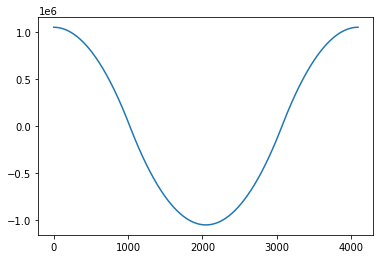

In [68]:
n = np.asarray([wav_4096(x) for x in range(4096)])
plt.plot(n)
plt.show()

In [168]:
sz = 2048
mag = 1<<11
cos_arr = np.asarray([int(cos(x* 2 * np.pi/sz) * mag) for x in range(sz)])

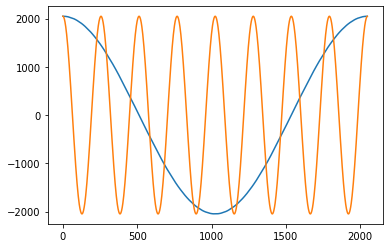

In [169]:
plt.plot(cos_arr)
plt.plot(np.asarray([cos_arr[(8*x) % sz] for x in range(sz)]))
plt.show()

In [170]:
min_diff = (2 * mag) + 1
for i in cos_arr:
    for j in cos_arr:
        if i!=j:
            min_diff = min(min_diff, abs(i - j))
min_diff

1